## Simulation parameters ##
# Frequecies:
wa =  1.0
wb =  1.0
wr =  0.5
ga =  0.01
gb =  0.1
# Displacements:
chi_a =  0.0002
chi_b =  0.020000000000000004
chi_ab =  0.002
chi_ba =  0.002
disp_a =  0.0 , disp_b =  0.0
disp_a = 0.00000, disp_b = 0.00000
# External fields:
NONE
# States:
dim_Fock =  7
Cavity A is initially in a Fock state: na =  0
Cavity B is initially in a Fock state: nb =  0
MR is initially in a Fock state: nr =  0
# Dissipation parameters:
kappa_a =  1e-06
kappa_b =  1e-06
gamma =  0
n_th_a =  0.2
n_th_b =  0.2
n_th_r =  0
# timelist in M.E. simulation:
t0 =  0 , tf =  250 , nt =  1000
# timelist in Spectrum simulation:
t0_2 =  0 , tf_2 =  1000 , nt_2 =  5000


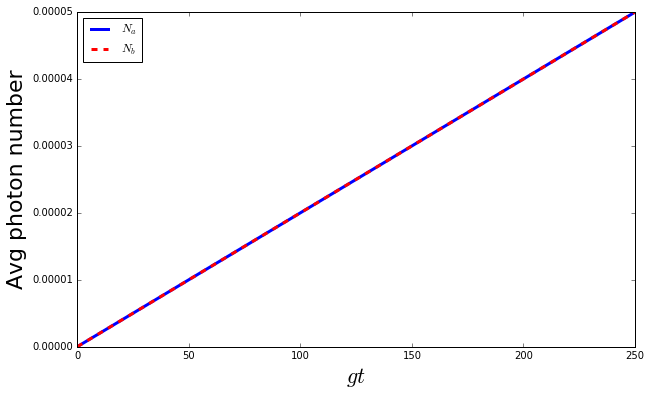

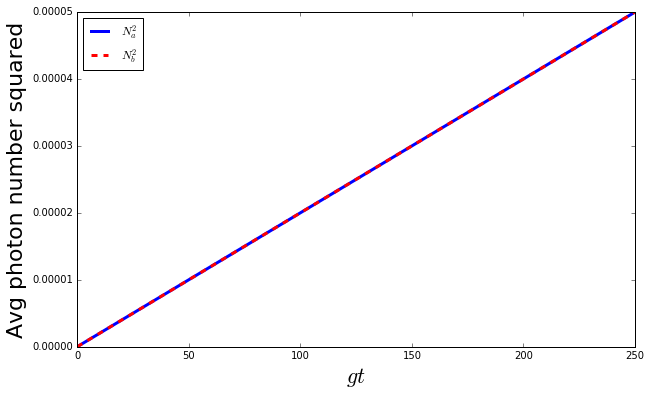

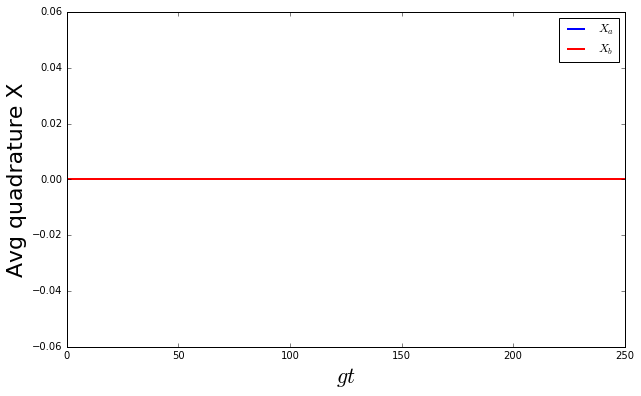

In [125]:
import matplotlib.pyplot as plt
from numpy import *
from qutip import *
from IPython.display import Image
from numpy.linalg import *
import multiprocessing as mp
import scipy.constants as sc
import time
import datetime
import os
#############################################

name = "Two-cavity-modes-coupled-to-a-mechanical-oscillator"
author = "Alessandro Santana"

time_index = datetime.datetime.now().strftime("Date[%Y-%m-%d]_Time[%Hh%Mm%Ss]")

save_path = "Data/" + time_index + "/"
try:
    os.mkdir(save_path)
except OSError:
    print ("Creation of the directory %s failed" % save_path)
    
#############################################
    
# definitions

# negativity
def negativity(sigma):
    #Partial transpose of sigma
    sigmapt = partial_transpose(sigma,(0,1))
    #Eigenvalues of Sigmapt
    evals = sigmapt.eigenenergies()
    #Sum of negative eigenvalues
    s = 0
    l = sigma.shape[0]
    for i in range(0,l):
        s = s + abs((evals[i] - abs(evals[i])))
    return s

# print simulation parameters
def parameters():
    print("## Simulation parameters ##")
    print("# Frequecies:")
    print("wa = ", wa)
    print("wb = ", wb)
    print("wr = ", wr)
    print("ga = ", ga)
    print("gb = ", gb)
    print("# Displacements:")
    print("chi_a = ", chi_a)
    print("chi_b = ", chi_b)
    print("chi_ab = ", chi_ab)
    print("chi_ba = ", chi_ba)
    print("disp_a = ", na*chi_a + nb*chi_ab,", disp_b = ", na*chi_ba + nb*chi_b)
    print("disp_a = %.5f, disp_b = %.5f"% (na*chi_a + nb*chi_ab, na*chi_ba + nb*chi_b))
    print("# External fields:")
    if E_a > 0:
        print("Cavity A drive:")
        print("E_a = ", E_a)
    if E_b > 0:
        print("Cavity B drive:")
        print("E_b = ", E_b)
    else:
        if E_a == 0:
            print("NONE")
    print("# States:")
    print("dim_Fock = ", N)
    if na >= 0:
        print("Cavity A is initially in a Fock state: na = ", na)
    else:
        print("Cavity A is initially in a Coherent state:")
        print("alpha_a = ", alpha_a,", na_avg = ", na_avg)
    if nb >= 0:
        print("Cavity B is initially in a Fock state: nb = ", nb)
    else:
        print("Cavity B is initially in a Coherent state:")
        print("alpha_b = ", alpha_b,", nb_avg = ", nb_avg)
    if nr >= 0:
        print("MR is initially in a Fock state: nr = ", nr)
    print("# Dissipation parameters:")
    print("kappa_a = ", kappa_a)
    print("kappa_b = ", kappa_b)
    print("gamma = ", gamma)
    print("n_th_a = ", n_th_a)
    print("n_th_b = ", n_th_b)
    print("n_th_r = ", n_th_r)
    print("# timelist in M.E. simulation:")
    print("t0 = ", t0,", tf = ", tf,", nt = ", nt)
    print("# timelist in Spectrum simulation:")
    print("t0_2 = ", t0_2,", tf_2 = ", tf_2,", nt_2 = ", nt_2)
    return 

# save simulation parameters
def save_parameters():
    filename = name + "-" + "parameters" + "-" + time_index + ".txt"
    file = open(save_path + filename,"w")
    file.write("Simulation:" + name + "\n")
    file.write("Author:" + author + "\n\n")
    file.write("## Simulation parameters ##\n")
    file.write("# Frequecies:\n")
    file.write("wa = %.2f\n" % wa)
    file.write("wb = %.2f\n" % wb)
    file.write("wr = %.2f\n" % wr)
    file.write("ga = %.3f\n" % ga)
    file.write("gb = %.3f\n" % gb)
    file.write("# Displacements:\n")
    file.write("chi_a = %.5f\n" % chi_a)
    file.write("chi_b = %.5f\n" % chi_b)
    file.write("chi_ab = %.5f\n" % chi_ab)
    file.write("chi_ba = %.5f\n" % chi_ba)
    file.write("disp_a = %.5f, disp_b = %.5f\n" % (na*chi_a + nb*chi_ab, na*chi_ba + nb*chi_b))
    file.write("# External fields:\n")
    if E_a > 0:
        file.write("Cavity A drive:\n")
        file.write("E_a = %.4f, we_a = %.2f\n" % (E_a,we_a))
    if E_b > 0:
        file.write("Cavity B drive:\n")
        file.write("E_b = %.4f, we_b = %.2f\n" % (E_b,we_b))
    else:
        if E_a == 0:
            file.write("NONE\n")
    file.write("# States:\n")
    file.write("dim_Fock = %d\n" % N)
    if na >= 0:
        file.write("Cavity A is initially in a Fock state: na = %d\n" % na)
    else:
        file.write("Cavity A is initially in a Coherent state:\n")
        file.write("alpha_a = %.2f, na_avg = %.2f\n" % (alpha_a, na_avg))
    if nb >= 0:
        file.write("Cavity B is initially in a Fock state: nb = %d\n" % nb)
    else:
        file.write("Cavity B is initially in a Coherent state:\n")
        file.write("alpha_b = %.2f, nb_avg = %.2f\n" % (alpha_b, nb_avg))
    if nr >= 0:
        file.write("MR is initially in a Fock state: nr = %d\n" % nr)
    file.write("# Dissipation parameters:\n")
    file.write("kappa_a = %.4f\n" % kappa_a)
    file.write("kappa_b = %.4f\n" % kappa_b)
    file.write("gamma = %.4f\n" % gamma)
    file.write("n_th_a = %.3f\n" % n_th_a)
    file.write("n_th_b = %.3f\n" % n_th_b)
    file.write("n_th_r = %.3f\n" % n_th_r)
    file.write("# timelist for qutip.mesolve():\n")
    file.write("t0 = %.1f, tf = %.1f, nt = %d\n" % (t0,tf,nt))
    file.write("# timelist for qutip.correlation_2op_2t() simulation:\n")
    file.write("t0_2 = %.1f, tf_2 = %.1f, nt_2 = %d\n" % (t0_2,tf_2,nt_2))
    file.write("# wlist for qutip.spectrum() simulation:\n")
    file.write("w0 = %.1f, wf = %.1f, nw = %d" % (w0,wf,nw))
    file.close()
    return 

#############################################

# parameters

# frequency related
wa = 1.0 #* 2 * pi    # cavity a frequency
wb = 1.0 #* 2 * pi    # cavity b frequency
wr = 0.5 #* 2 * pi    # mechanical oscilattor frequency
Da = wa - wr
Db = wb - wr
ga  = 0.01            # coupling strength cavity a
gb  = 0.1             # coupling strength cavity b
kappa_a = 1e-06       # cavity a dissipation rate
kappa_b = 1e-06       # cavity b dissipation rate
gamma = 0             # mechanic damping rate

E_a = 0                  # External field coupling (cav A)
we_a = 0.0               # External field frequency (cav A)
E_b = 0                  # External field coupling (cav B)
we_b = 0.0               # External field frequency (cav B)

chi_a = ga**2/(wa*wr) 
chi_b = gb**2/(wb*wr)
chi_ab= ga*gb/(wa*wr)
chi_ba= ga*gb/(wb*wr)

# number related
na = 0
nb = 0
nr = 0
alpha_a = 0
alpha_b = 0
na_avg = alpha_a**2
nb_avg = alpha_b**2

N = 7                # Fock space dimension

n_th_a = 0.2         # avg number of thermal bath excitation coupled to a
n_th_b = 0.2         # avg number of thermal bath excitation coupled to b
n_th_r = 0         # avg number of thermal bath excitation coupled to r

# lists
t0 = 0
tf = 250
nt = 1000
dt = (tf-t0)/nt
tlist = linspace(t0,tf,nt)

t0_2 = 0
tf_2 = 1000
nt_2 = 5000

w0 = 0
wf = 2
nw = 8000


save_parameters()
#############################################

# initial state
if na >= 0:
    state_a_t0 = fock(N, na)
else:
    state_a_t0 = coherent(N, alpha_a)
if nb >= 0:
    state_b_t0 = fock(N, nb)
else:
    state_b_t0 = coherent(N, alpha_b)
if nr >= 0:
    state_r_t0 = fock(N,nr)

state_t0 = tensor(state_a_t0,state_b_t0) #,state_r_t0)


#############################################

# operators

# annihilation
a  = tensor(destroy(N),qeye(N)) #,qeye(N))
b  = tensor(qeye(N),destroy(N)) #,qeye(N))
#r  = tensor(qeye(N),qeye(N)),destroy(N))

# number
Na = a.dag() * a
Nb = b.dag() * b
#Nr = r.dag() * r

# quadrature X
Xa = a.dag() + a
Xb = b.dag() + b
#Xr = r.dag() + r

# operator alpha
alpha = (ga/wr)*Na + (gb/wr)*Nb


#############################################

# Hamiltonian
Hvec = []
#Hvec.append(wa*Na)                           # Field mode a free energy
#Hvec.append(wb*Nb)                           # Field mode b free energy  
#Hvec.append(wr*Nr)                           # Mechanical oscilattor energy
#Hvec.append(-ga*Na*Xr)                       # interaction cavity-a with mechanical osc. (1st order)  
#Hvec.append(-gb*Nb*Xr)                       # interaction cavity-a with mechanical osc. (1st order)
Hvec.append(wa*Na*(1-(ga/wa)*alpha))          # interaction cavity-a with mechanical osc. (1st order)   
Hvec.append(wb*Nb*(1-(gb/wb)*alpha))          # interaction cavity-b with mechanical osc. (1st order)
Hvec.append(E_a*Xa)
Hvec.append(-we_a*Na)
Hvec.append(E_b*Xb)
Hvec.append(-we_b*Nb)
   
H = 0
for i in range(len(Hvec)):
    H = H + Hvec[i]


#############################################

# collapse operators
c_ops = []

# Relaxations, temperature = 0 or >0

# cavity-a relaxation
rate = kappa_a * (1 + n_th_a)
if rate > 0.0:
    c_ops.append(sqrt(rate) * a)
    
# cavity-b relaxation
rate = kappa_b * (1 + n_th_b)
if rate > 0.0:
    c_ops.append(sqrt(rate) * b)
    
# mechanical oscillator relaxation
rate = gamma * (1 + n_th_r)
if rate > 0.0:
    c_ops.append(sqrt(rate) * r)
    
# Excitations, only temperature > 0   
    
# cavity-a excitation
rate = kappa_a * n_th_a
if rate > 0.0:
    c_ops.append(sqrt(rate) * a.dag())

# cavity-b excitation    
rate = kappa_b * n_th_b
if rate > 0.0:
    c_ops.append(sqrt(rate) * b.dag())
    
# mechanical oscillator excitation    
rate = gamma * n_th_r
if rate > 0.0:
    c_ops.append(sqrt(rate) * r.dag())


#############################################

# Master equation solve function

Op_list = []
#Op_list = [Na,Nb,Xa,Xb]
comp = mesolve(H, state_t0, tlist, c_ops, Op_list)

#############################################

# Entanglement measures for N = 2

if N < 3:
    negativity_ab = []  
    negativity_ar = []
    negativity_br = []
    concurrence_ab = []
    concurrence_ar = []
    concurrence_br = []
    for i in range(nt):
        rho_t = comp.states[i]
        rho_ab_t = ptrace(rho_t, [0,1])
        rho_ar_t = ptrace(rho_t, [0,2])
        rho_br_t = ptrace(rho_t, [1,2])
        negativity_ab.append(negativity(rho_ab_t))
        negativity_ar.append(negativity(rho_ar_t))
        negativity_br.append(negativity(rho_br_t))
        concurrence_ab.append(concurrence(rho_ab_t))
        concurrence_ar.append(concurrence(rho_ar_t))
        concurrence_br.append(concurrence(rho_br_t))
    ###### 1st plot ######
    fig, axes = plt.subplots(1, 1, figsize=(10,6))
    axes.plot(tlist, (real(negativity_ab)),'b',label= "a-b", lw=2.0)
    axes.plot(tlist, (real(negativity_ar)),'r' ,label= "a-r", lw=2.0)
    axes.plot(tlist, (real(negativity_ar)),'g' ,label= "b-r", lw=2.0)
    axes.legend(loc=0)
    axes.set_ylim(0, 1.01)
    axes.set_xlabel(r'$g t$',rotation=0,fontsize= 22.0)
    axes.set_ylabel('Negatividade  $\mathcal{N}$ ',rotation=90,fontsize= 22.0)
    plt.show()
    ###### 2nd plot ######
    fig, axes = plt.subplots(1, 1, figsize=(10,6))
    axes.plot(tlist, (real(concurrence_ab)),'b',label= "a-b", lw=2.0)
    axes.plot(tlist, (real(concurrence_ar)),'r' ,label= "a-r", lw=2.0)
    axes.plot(tlist, (real(concurrence_br)),'g' ,label= "b-r", lw=2.0)
    axes.legend(loc=0)
    axes.set_ylim(0, 1.01)
    axes.set_xlabel(r'$g t$',rotation=0,fontsize= 22.0)
    axes.set_ylabel('Concurrence  $\mathcal{C}$ ',rotation=90,fontsize= 22.0)
    plt.show()
#else:
#    print("Error: Invalid system dimensions. The negativity and concurrence cannot be calculated.")
    
#############################################

# Expected values

Na_m = expect(Na, comp.states)
Nb_m = expect(Nb, comp.states)
#Nr_m = expect(Nr, comp.states)

Xa_m = expect(Xa, comp.states)
Xb_m = expect(Xb, comp.states)
#Xr_m = expect(Xr, comp.states)

Na_m_sqrd = expect(Na*Na, comp.states)
Nb_m_sqrd = expect(Nb*Nb, comp.states)

parameters()
###### 1st plot ######
fig, axes = plt.subplots(1, 1, figsize=(10,6))
axes.plot(tlist, (real(Na_m)),'b',label= "$N_a$", lw=3.0)
axes.plot(tlist, (real(Nb_m)),'r--' ,label= "$N_b$", lw=3.0)
#axes.plot(tlist, (real(Nr_m)),'g' ,label= "$N_r$", lw=3.0)
axes.legend(loc=0)
axes.set_xlabel(r'$g t$',rotation=0,fontsize= 22.0)
axes.set_ylabel('Avg photon number',rotation=90,fontsize= 22.0)
filename = "NumbN-"
save(save_path + filename + time_index,(tlist,Na_m, Nb_m))
plt.savefig(save_path + filename + time_index + ".pdf", bbox_inches='tight');
plt.savefig(save_path + filename + time_index + ".png", bbox_inches='tight');
plt.show()
###### 2nd plot ######
fig, axes = plt.subplots(1, 1, figsize=(10,6))
axes.plot(tlist, (real(Na_m_sqrd)),'b',label= "$N_a^2$", lw=3.0)
axes.plot(tlist, (real(Nb_m_sqrd)),'r--' ,label= "$N_b^2$", lw=3.0)
axes.legend(loc=0)
axes.set_xlabel(r'$g t$',rotation=0,fontsize= 22.0)
axes.set_ylabel('Avg photon number squared',rotation=90,fontsize= 22.0)
filename = "NumbN_squared-"
save(save_path + filename + time_index,(tlist,Na_m_sqrd, Nb_m_sqrd))
plt.savefig(save_path + filename + time_index + ".pdf", bbox_inches='tight');
plt.savefig(save_path + filename + time_index + ".png", bbox_inches='tight');
plt.show()
###### 3rd plot ######
fig, axes = plt.subplots(1, 1, figsize=(10,6))
axes.plot(tlist, (real(Xa_m)),'b',label= "$X_a$", lw=2.0)
axes.plot(tlist, (real(Xb_m)),'r' ,label= "$X_b$", lw=2.0)
#axes.plot(tlist, (real(Xr_m)),'g' ,label= "$X_r$", lw=2.0)
axes.legend(loc=0)
#axes.set_ylim(-4, 4)
axes.set_xlabel(r'$g t$',rotation=0,fontsize= 22.0)
axes.set_ylabel('Avg quadrature X',rotation=90,fontsize= 22.0)
filename = "quadX-"
save(save_path + filename + time_index,(tlist,Xa_m, Xb_m))
plt.savefig(save_path + filename + time_index + ".pdf", bbox_inches='tight');
plt.savefig(save_path + filename + time_index + ".png", bbox_inches='tight');
plt.show()
    
#############################################


## Simulation parameters ##
# Frequecies:
wa =  1.0
wb =  1.0
wr =  0.5
ga =  0.01
gb =  0.1
# Displacements:
chi_a =  0.0002
chi_b =  0.020000000000000004
chi_ab =  0.002
chi_ba =  0.002
disp_a =  0.0 , disp_b =  0.0
disp_a = 0.00000, disp_b = 0.00000
# External fields:
NONE
# States:
dim_Fock =  7
Cavity A is initially in a Fock state: na =  0
Cavity B is initially in a Fock state: nb =  0
MR is initially in a Fock state: nr =  0
# Dissipation parameters:
kappa_a =  1e-06
kappa_b =  1e-06
gamma =  0
n_th_a =  0.2
n_th_b =  0.2
n_th_r =  0
# timelist in M.E. simulation:
t0 =  0 , tf =  250 , nt =  1000
# timelist in Spectrum simulation:
t0_2 =  0 , tf_2 =  1000 , nt_2 =  5000


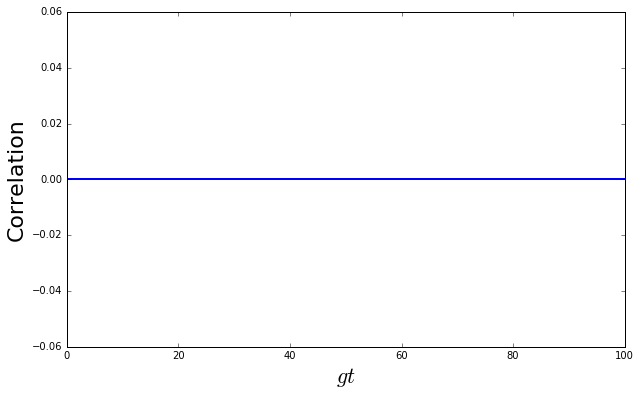

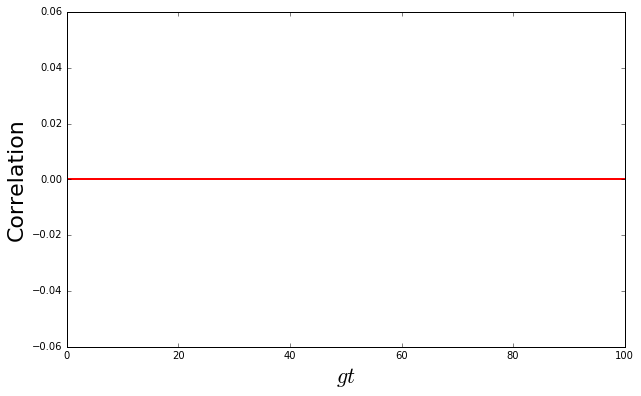

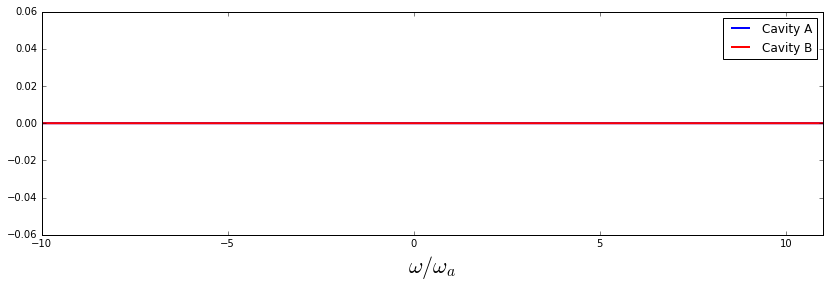

In [126]:
# Correlation 

tlist2 = linspace(t0_2,tf_2,nt_2)
corr_a = correlation_2op_2t(H, state_t0, None, tlist2, [],  a.dag(), a)
corr_b = correlation_2op_2t(H, state_t0, None, tlist2, [],  b.dag(), b)
#corr_r = correlation_2op_2t(H, state_t0, None, tlist2, [],  r.dag(), r)


wlist1, Sa = spectrum_correlation_fft(tlist2, corr_a)
wlist2, Sb = spectrum_correlation_fft(tlist2, corr_b)
#wlist2, Sr = spectrum_correlation_fft(tlist2, corr_r)

parameters()

##########
fig, axes = plt.subplots(1, 1, figsize=(10,6))
axes.plot(tlist2, (real(corr_a)),'b', lw=2.0)
#axes.legend(loc=0)
axes.set_xlabel(r'$g t$',rotation=0,fontsize= 22.0)
axes.set_ylabel('Correlation',rotation=90,fontsize= 22.0)
axes.set_xlim(0,100)
filename = "CorrelationA-"
save(save_path + filename + time_index,(tlist2,corr_a))
plt.savefig(save_path + filename + time_index + ".pdf", bbox_inches='tight');
plt.savefig(save_path + filename + time_index + ".png", bbox_inches='tight');
plt.show()
##########
fig, axes = plt.subplots(1, 1, figsize=(10,6))
axes.plot(tlist2, (real(corr_b)),'r', lw=2.0)
#axes.legend(loc=0)
axes.set_xlabel(r'$g t$',rotation=0,fontsize= 22.0)
axes.set_ylabel('Correlation',rotation=90,fontsize= 22.0)
axes.set_xlim(0,100)
filename = "CorrelationB-"
save(save_path + filename + time_index,(tlist2,corr_b))
plt.savefig(save_path + filename + time_index + ".pdf", bbox_inches='tight');
plt.savefig(save_path + filename + time_index + ".png", bbox_inches='tight');
plt.show()
##########
#fig, axes = plt.subplots(1, 1, figsize=(10,6))
#axes.plot(tlist2, (real(corr_r)),'g', lw=2.0)
#axes.legend(loc=0)
#axes.set_xlabel(r'$g t$',rotation=0,fontsize= 22.0)
#axes.set_ylabel('Correlation',rotation=90,fontsize= 22.0)
#axes.set_xlim(0,100)
#plt.show()
##########
fig, axes = plt.subplots(1, 1, figsize=(14,4))
axes.plot(wlist1, (real(Sa)),'b',label='Cavity A', lw=2.0)
axes.plot(wlist2, (real(Sb)),'r',label='Cavity B', lw=2.0)
axes.legend(loc=0)
axes.set_xlabel(r'$\omega/\omega_a$',rotation=0,fontsize= 22.0)
#axes.set_ylabel('Correlation',rotation=90,fontsize= 22.0)
axes.set_xlim(-10, 11)
filename = "Spectrum-Corr-FFT-"
save(save_path + filename + time_index,(tlist2,Sa,Sb))
plt.savefig(save_path + filename + time_index + ".pdf", bbox_inches='tight');
plt.savefig(save_path + filename + time_index + ".png", bbox_inches='tight');
plt.show()

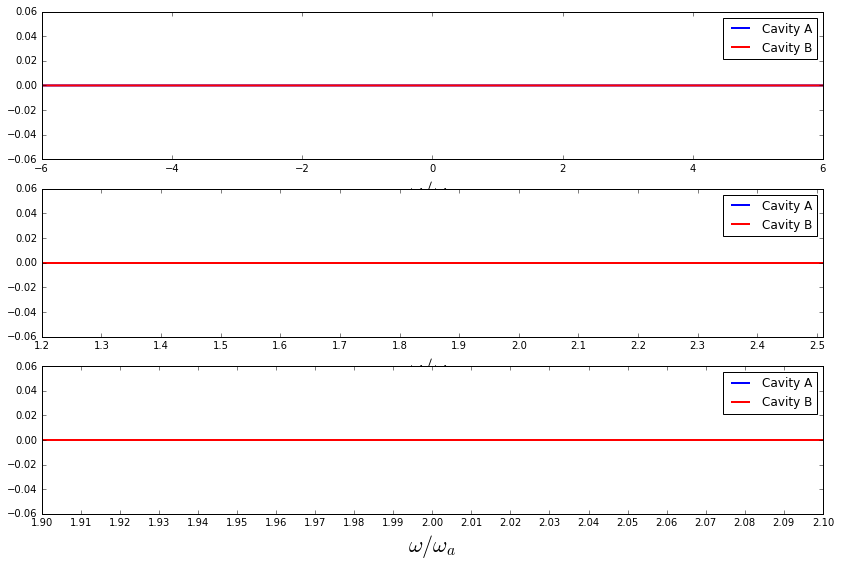

In [127]:
fig, axes = plt.subplots(3,1, figsize=(14,9))

axes[0].plot(wlist1, (real(Sa)),'b',label='Cavity A', lw=2.0)
axes[0].plot(wlist2, (real(Sb)),'r',label='Cavity B', lw=2.0)
axes[0].legend(loc=0)
axes[0].set_xlabel(r'$\omega/\omega_a$',rotation=0,fontsize= 22.0)
axes[0].set_xlim(-6, 6)

axes[1].plot(wlist1, (real(Sa)),'b',label='Cavity A', lw=2.0)
axes[1].plot(wlist2, (real(Sb)),'r',label='Cavity B', lw=2.0)
axes[1].legend(loc=0)
axes[1].set_xlabel(r'$\omega/\omega_a$',rotation=0,fontsize= 22.0)
axes[1].set_xlim(1.2, 2.51)
start, end = axes[1].get_xlim()
axes[1].xaxis.set_ticks(arange(start, end, 0.10))

axes[2].plot(wlist1, (real(Sa)),'b',label='Cavity A', lw=2.0)
axes[2].plot(wlist2, (real(Sb)),'r',label='Cavity B', lw=2.0)
axes[2].legend(loc=0)
axes[2].set_xlabel(r'$\omega/\omega_a$',rotation=0,fontsize= 22.0)
axes[2].set_xlim(1.9, 2.1)
start, end = axes[2].get_xlim()
axes[2].xaxis.set_ticks(arange(start, end, chi_b/2))

filename = "Spectrum-Corr-FFT-2-"
plt.savefig(save_path + filename + time_index + ".pdf", bbox_inches='tight');
plt.savefig(save_path + filename + time_index + ".png", bbox_inches='tight');
plt.show()

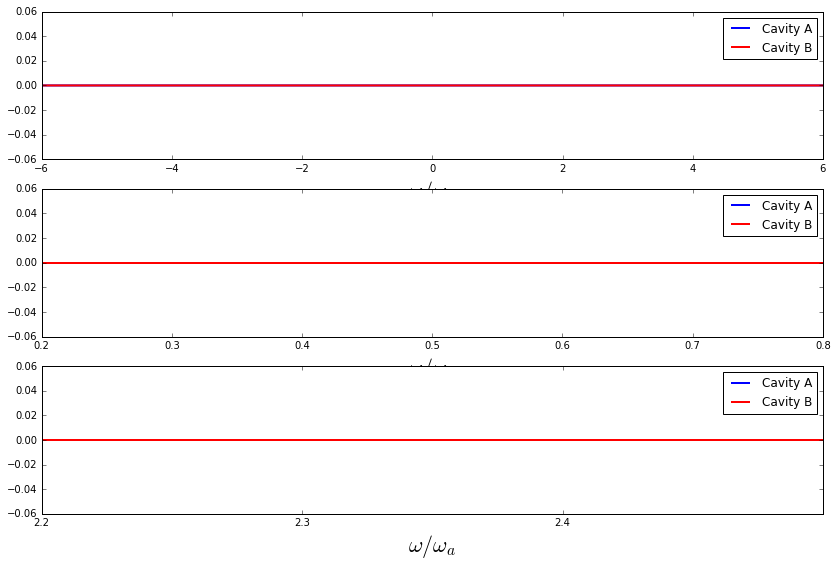

In [128]:
fig, axes = plt.subplots(3,1, figsize=(14,9))

axes[0].plot(wlist1, (real(Sa)),'b',label='Cavity A', lw=2.0)
axes[0].plot(wlist2, (real(Sb)),'r',label='Cavity B', lw=2.0)
axes[0].legend(loc=0)
axes[0].set_xlabel(r'$\omega/\omega_a$',rotation=0,fontsize= 22.0)
axes[0].set_xlim(-6, 6)

axes[1].plot(wlist1, (real(Sa)),'b',label='Cavity A', lw=2.0)
axes[1].plot(wlist2, (real(Sb)),'r',label='Cavity B', lw=2.0)
axes[1].legend(loc=0)
axes[1].set_xlabel(r'$\omega/\omega_a$',rotation=0,fontsize= 22.0)
axes[1].set_xlim(0.2, 0.8)
start, end = axes[1].get_xlim()
axes[1].xaxis.set_ticks(arange(start, end, 0.10))

axes[2].plot(wlist1, (real(Sa)),'b',label='Cavity A', lw=2.0)
axes[2].plot(wlist2, (real(Sb)),'r',label='Cavity B', lw=2.0)
axes[2].legend(loc=0)
axes[2].set_xlabel(r'$\omega/\omega_a$',rotation=0,fontsize= 22.0)
axes[2].set_xlim(2.2,2.5)
start, end = axes[2].get_xlim()
axes[2].xaxis.set_ticks(arange(start, end, 0.1))

filename = "Spectrum-Corr-FFT-3-"
plt.savefig(save_path + filename + time_index + ".pdf", bbox_inches='tight');
plt.savefig(save_path + filename + time_index + ".png", bbox_inches='tight');
plt.show()

In [129]:
wlist = linspace(w0,wf,nw)
Sa_2 = spectrum(H, wlist, c_ops,  a.dag(), a)
Sb_2 = spectrum(H, wlist, c_ops,  b.dag(), b)

start
end
start
end


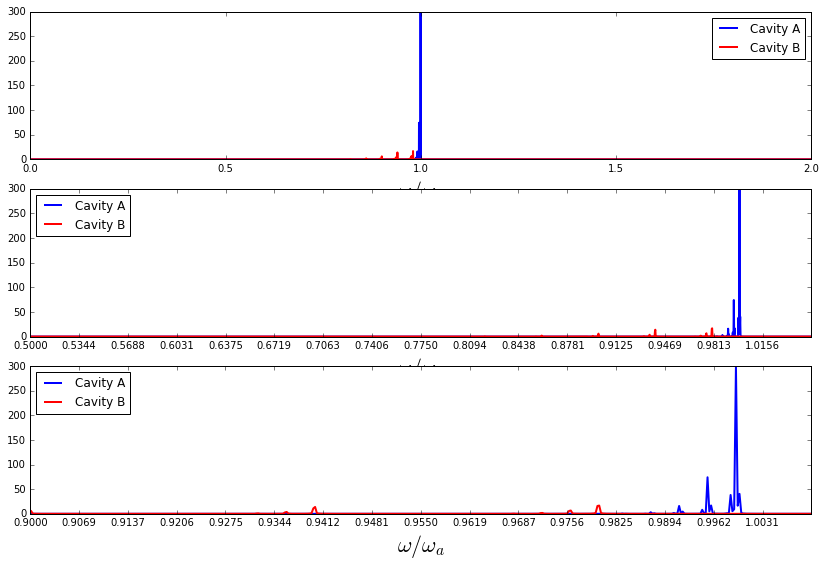

In [130]:
fig, axes = plt.subplots(3,1, figsize=(14,9))

axes[0].plot(wlist, (real(Sa_2)),'b',label='Cavity A', lw=2.0)
axes[0].plot(wlist, (real(Sb_2)),'r',label='Cavity B', lw=2.0)
axes[0].legend(loc=0)
axes[0].set_xlabel(r'$\omega/\omega_a$',rotation=0,fontsize= 22.0)
axes[0].set_xlim(w0, wf)

axes[1].plot(wlist, (real(Sa_2)),'b',label='Cavity A', lw=2.0)
axes[1].plot(wlist, (real(Sb_2)),'r',label='Cavity B', lw=2.0)
axes[1].legend(loc=0)
axes[1].set_xlabel(r'$\omega/\omega_a$',rotation=0,fontsize= 22.0)
axes[1].set_xlim(0.5, 1.05)
start, end = axes[1].get_xlim()
axes[1].xaxis.set_ticks(arange(start, end, ((end-start)/16)))

axes[2].plot(wlist, (real(Sa_2)),'b',label='Cavity A', lw=2.0)
axes[2].plot(wlist, (real(Sb_2)),'r',label='Cavity B', lw=2.0)
axes[2].legend(loc=0)
axes[2].set_xlabel(r'$\omega/\omega_a$',rotation=0,fontsize= 22.0)
axes[2].set_xlim(0.9,1.01)
#axes[2].set_ylim(0,15)
start, end = axes[2].get_xlim()
axes[2].xaxis.set_ticks(arange(start, end, (end-start)/16))

filename = "Spectrum()-"
save(save_path + filename + time_index,(wlist,Sa_2,Sb_2))
plt.savefig(save_path + filename + time_index + ".pdf", bbox_inches='tight');
plt.savefig(save_path + filename + time_index + ".png", bbox_inches='tight');
plt.show()

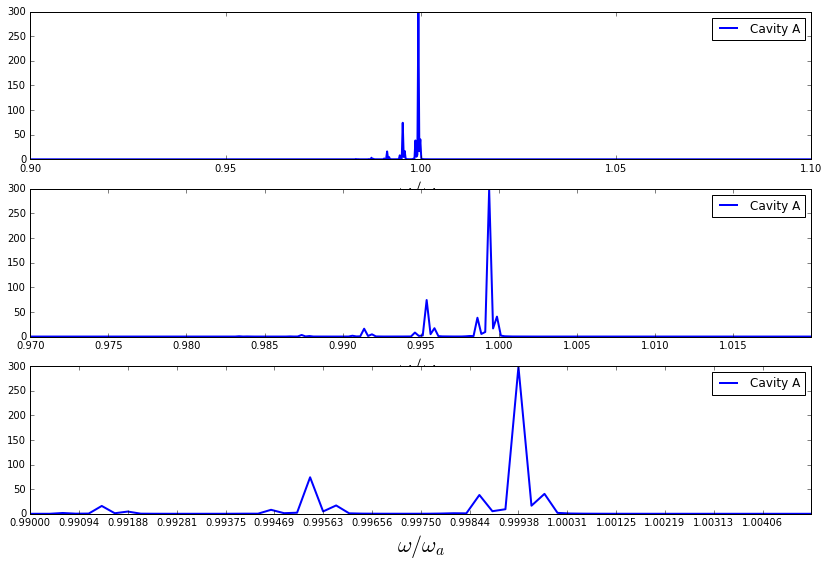

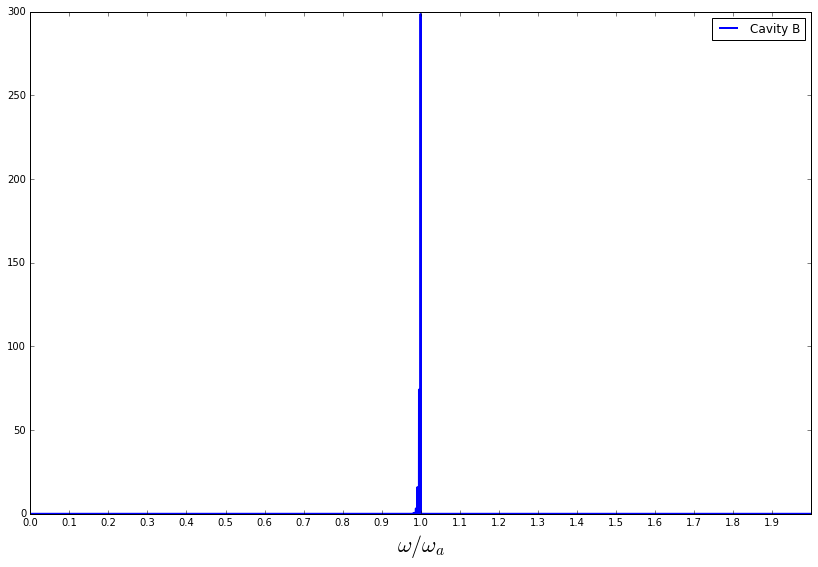

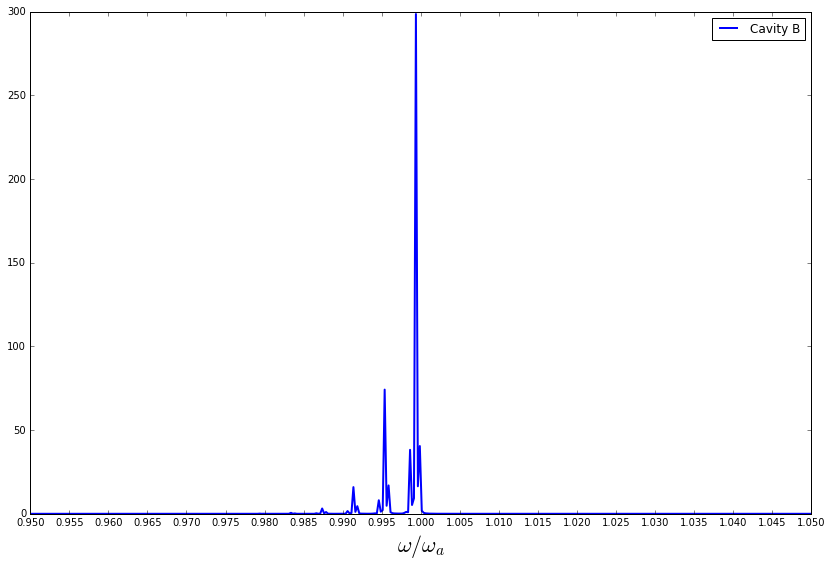

In [142]:
fig, axes = plt.subplots(3,1, figsize=(14,9))

axes[0].plot(wlist, (real(Sa_2)),'b',label='Cavity A', lw=2.0)
axes[0].legend(loc=0)
axes[0].set_xlabel(r'$\omega/\omega_a$',rotation=0,fontsize= 22.0)
axes[0].set_xlim(0.9, 1.1)

axes[1].plot(wlist, (real(Sa_2)),'b',label='Cavity A', lw=2.0)
axes[1].legend(loc=0)
axes[1].set_xlabel(r'$\omega/\omega_a$',rotation=0,fontsize= 22.0)
axes[1].set_xlim(0.97, 1.02)
start, end = axes[1].get_xlim()
axes[1].xaxis.set_ticks(arange(start, end, (end-start)/10))

axes[2].plot(wlist, (real(Sa_2)),'b',label='Cavity A', lw=2.0)
axes[2].legend(loc=0)
axes[2].set_xlabel(r'$\omega/\omega_a$',rotation=0,fontsize= 22.0)
axes[2].set_xlim(0.99,1.005)
#axes[2].set_ylim(0,15)
start, end = axes[2].get_xlim()
axes[2].xaxis.set_ticks(arange(start, end, (end-start)/16))

filename = "Spectrum()-A-"
plt.savefig(save_path + filename + time_index + ".pdf", bbox_inches='tight');
plt.savefig(save_path + filename + time_index + ".png", bbox_inches='tight');
plt.show()

####

fig, axes = plt.subplots(1,1, figsize=(14,9))
axes.plot(wlist, (real(Sa_2)),'b',label='Cavity B', lw=2.0)
axes.legend(loc=0)
axes.set_xlabel(r'$\omega/\omega_a$',rotation=0,fontsize= 22.0)
axes.set_xlim(w0, wf)
start, end = axes.get_xlim()
axes.xaxis.set_ticks(arange(start, end, 0.1))
filename = "Spectrum()-A-2-"
plt.savefig(save_path + filename + time_index + ".pdf", bbox_inches='tight');
plt.savefig(save_path + filename + time_index + ".png", bbox_inches='tight');
plt.show()

####

fig, axes = plt.subplots(1,1, figsize=(14,9))
axes.plot(wlist, (real(Sa_2)),'b',label='Cavity B', lw=2.0)
axes.legend(loc=0)
axes.set_xlabel(r'$\omega/\omega_a$',rotation=0,fontsize= 22.0)
axes.set_xlim(0.95, 1.05)
start, end = axes.get_xlim()
axes.xaxis.set_ticks(arange(start, end, 0.005))
filename = "Spectrum()-A-3-"
plt.savefig(save_path + filename + time_index + ".pdf", bbox_inches='tight');
plt.savefig(save_path + filename + time_index + ".png", bbox_inches='tight');
plt.show()

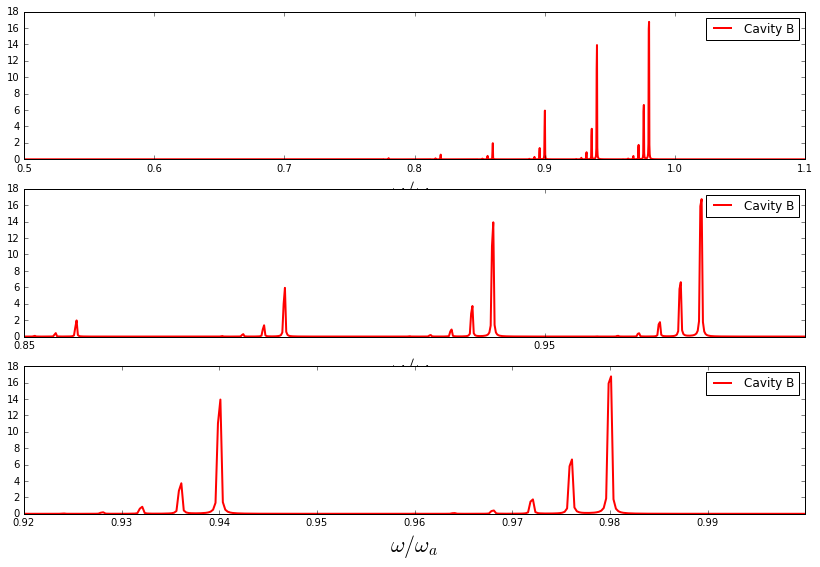

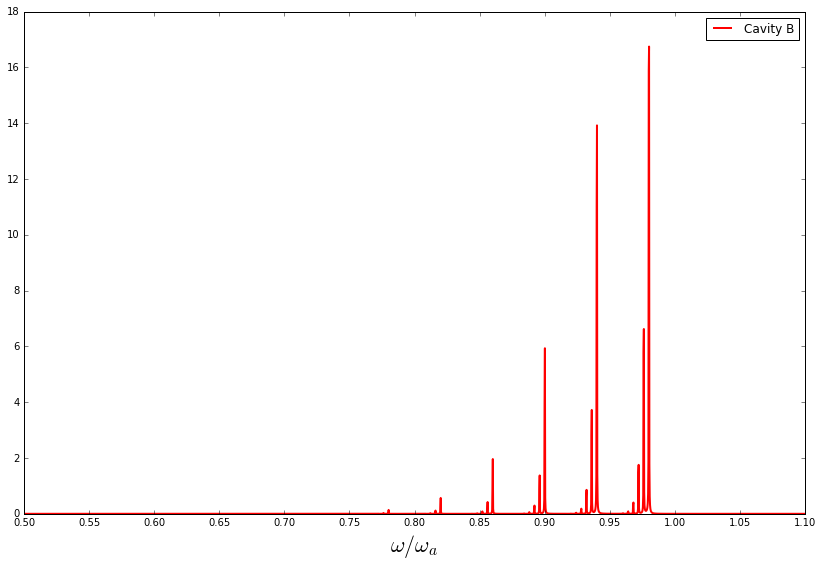

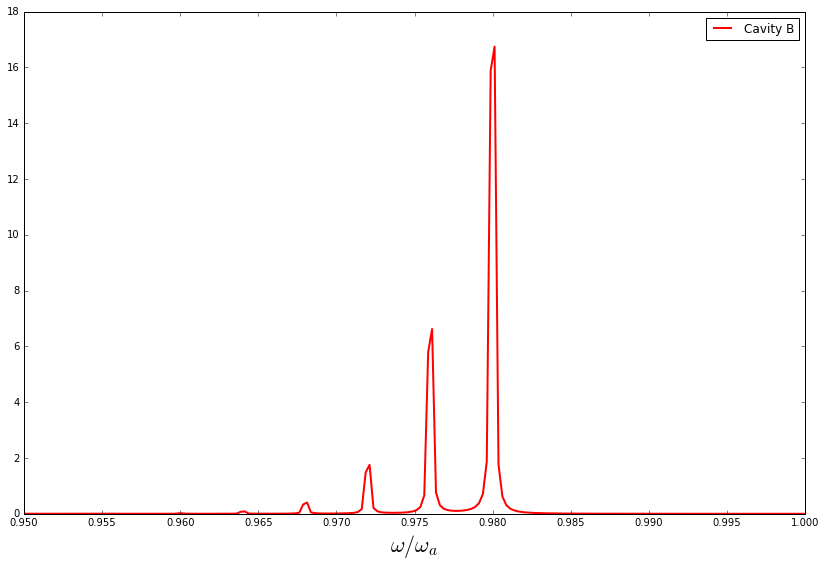

In [145]:
fig, axes = plt.subplots(3,1, figsize=(14,9))

axes[0].plot(wlist, (real(Sb_2)),'r',label='Cavity B', lw=2.0)
axes[0].legend(loc=0)
axes[0].set_xlabel(r'$\omega/\omega_a$',rotation=0,fontsize= 22.0)
axes[0].set_xlim(0.5, 1.1)

axes[1].plot(wlist, (real(Sb_2)),'r',label='Cavity B', lw=2.0)
axes[1].legend(loc=0)
axes[1].set_xlabel(r'$\omega/\omega_a$',rotation=0,fontsize= 22.0)
axes[1].set_xlim(0.85, 1.)
start, end = axes[1].get_xlim()
axes[1].xaxis.set_ticks(arange(start, end, 0.10))

axes[2].plot(wlist, (real(Sb_2)),'r',label='Cavity B', lw=2.0)
axes[2].legend(loc=0)
axes[2].set_xlabel(r'$\omega/\omega_a$',rotation=0,fontsize= 22.0)
axes[2].set_xlim(0.92,1.0)
#axes[2].set_ylim(0,1000)
start, end = axes[2].get_xlim()
axes[2].xaxis.set_ticks(arange(start, end, 0.01))

filename = "Spectrum()-B-"
plt.savefig(save_path + filename + time_index + ".pdf", bbox_inches='tight');
plt.savefig(save_path + filename + time_index + ".png", bbox_inches='tight');
plt.show()
#############

fig, axes = plt.subplots(1,1, figsize=(14,9))
axes.plot(wlist, (real(Sb_2)),'r',label='Cavity B', lw=2.0)
axes.legend(loc=0)
axes.set_xlabel(r'$\omega/\omega_a$',rotation=0,fontsize= 22.0)
axes.set_xlim(0.5, 1.1)
start, end = axes.get_xlim()
axes.xaxis.set_ticks(arange(start, end, 0.05))
filename = "Spectrum()-B-2-"
plt.savefig(save_path + filename + time_index + ".pdf", bbox_inches='tight');
plt.savefig(save_path + filename + time_index + ".png", bbox_inches='tight');
plt.show()


#############

fig, axes = plt.subplots(1,1, figsize=(14,9))
axes.plot(wlist, (real(Sb_2)),'r',label='Cavity B', lw=2.0)
axes.legend(loc=0)
axes.set_xlabel(r'$\omega/\omega_a$',rotation=0,fontsize= 22.0)
axes.set_xlim(0.95, 1.)
start, end = axes.get_xlim()
axes.xaxis.set_ticks(arange(start, end, 0.005))
filename = "Spectrum()-B-3-"
plt.savefig(save_path + filename + time_index + ".pdf", bbox_inches='tight');
plt.savefig(save_path + filename + time_index + ".png", bbox_inches='tight');
plt.show()

In [146]:
parameters()

## Simulation parameters ##
# Frequecies:
wa =  1.0
wb =  1.0
wr =  0.5
ga =  0.01
gb =  0.1
# Displacements:
chi_a =  0.0002
chi_b =  0.020000000000000004
chi_ab =  0.002
chi_ba =  0.002
disp_a =  0.0 , disp_b =  0.0
disp_a = 0.00000, disp_b = 0.00000
# External fields:
NONE
# States:
dim_Fock =  7
Cavity A is initially in a Fock state: na =  0
Cavity B is initially in a Fock state: nb =  0
MR is initially in a Fock state: nr =  0
# Dissipation parameters:
kappa_a =  1e-06
kappa_b =  1e-06
gamma =  0
n_th_a =  0.2
n_th_b =  0.2
n_th_r =  0
# timelist in M.E. simulation:
t0 =  0 , tf =  250 , nt =  1000
# timelist in Spectrum simulation:
t0_2 =  0 , tf_2 =  1000 , nt_2 =  5000


In [147]:
ls -la Data

total 40
drwxr-xr-x 10 asantana outros 4096 Nov 12 15:41 ./
drwxr-xr-x 17 asantana outros 4096 Nov 12 15:49 ../
drwxr-xr-x  2 asantana outros 4096 Nov 12 12:28 Date[2019-11-12]_Time[12h28m58s]/
drwxr-xr-x  2 asantana outros 4096 Nov 12 12:30 Date[2019-11-12]_Time[12h30m02s]/
drwxr-xr-x  2 asantana outros 4096 Nov 12 12:30 Date[2019-11-12]_Time[12h30m21s]/
drwxr-xr-x  2 asantana outros 4096 Nov 12 13:28 Date[2019-11-12]_Time[13h28m10s]/
drwxr-xr-x  2 asantana outros 4096 Nov 12 13:39 Date[2019-11-12]_Time[13h28m30s]/
drwxr-xr-x  2 asantana outros 4096 Nov 12 14:55 Date[2019-11-12]_Time[13h43m22s]/
drwxr-xr-x  2 asantana outros 4096 Nov 12 15:51 Date[2019-11-12]_Time[15h41m26s]/
drwxr-xr-x  2 asantana outros 4096 Nov 12 12:37 .ipynb_checkpoints/


In [148]:
from qutip.ipynbtools import version_table
version_table()

Software,Version
QuTiP,4.4.1
Numpy,1.16.2
SciPy,1.3.1
matplotlib,1.5.1
Cython,0.25.2
Number of CPUs,12
BLAS Info,OPENBLAS
IPython,6.1.0
Python,"3.5.2 (default, Sep 10 2016, 08:21:44) [GCC 5.4.0 20160609]"
OS,posix [linux]
